# **Model Explaination**

 We have four types of strategy : 


*   Always Cooperate (AC) : Has the maximum probability of sharing food and getting food in return.
*   Tit For Tat (TFT) : Decides based on the history of the agent at mercy.
*   Alternatively cooperate and defect (ALT) : Alternates between cooperate and defect.
*   Always Defect (AD) : Least willing to share food.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


basket_of_strat = {'AC':[1],'TFT':[],'ALT':[0.7,0.3],'AD':[0.4]}
pop_of_strat = {'AC':[0],'TFT':[0],'ALT':[0],'AD':[0]}
pop_of_size = {1:[0],2:[0]}
class Agent():
    '''
        This is the class of agents. Every agent will be an instance
        of this class. Each Agent has some food at any time and we'll
        store it's age also.
    '''
    def __init__(self,size,strat):
        '''
            Initialize properties of agent
        '''
        self.id = id
        self.size = size
        self.pos={'x':0,'y':0}
        self.food = 0
        self.age = 0
        self.strat_name = strat
        self.strat = basket_of_strat[self.strat_name]

class Environment():
    '''
        This class is for the environment. An environment is modelled as
        an n by n matrix. Each cell can host 1 unit of food, or 1 agent.
        Our simulation will have a day and a night in 1 iteration. In a 
        day, our agents will be spawned at random places in the grid and
        along with some food. the goal for an agent is to aquire as much
        food as it could. At night, the agents can choose to share excess
        food with another agent or to reproduce based on some probability.
        Agents that could not aquire food in the day would die in night. 
        We'll test what strategy lead to higher chance of survival of the
        population.
    '''
    def __init__(self,n=45,foodperday=100,repChance=0.5):
        '''
            Initializes environment
            n : Env Matrix size
            foodperday : Food unit to spawn everyday
            repChance : prob of agents to reproduce if they have >2 unit food.
        '''
        self.n = n #matrix size
        self.foodPerDay = foodperday
        self.reproductionChance = repChance
        self.pop_hist = []
        self.agents = []
        self.grid = self.__getEmptyMat()
        self.range = range # Range in which an agent can pick food
        self.curr_total_lived=0
    def setup(self, agents : list):
        '''
            Sets environment's agents to `agents`
            agents : List of Agents initialized using `Agent` class
        '''
        self.agents=agents
        print('population : ',len(self.agents))
        self.curr_total_lived=len(agents)
        for i in range(len(agents)):
            agents[i].id=i+1
            pop_of_size[agents[i].size][-1] += 1
            pop_of_strat[agents[i].strat_name][-1] += 1 
        self.__update()
        return
    def __update(self):
        '''
            updating the data of population.
        '''
        pop_of_size[1].append(pop_of_size[1][-1])
        pop_of_size[2].append(pop_of_size[2][-1])
        pop_of_strat['AC'].append(pop_of_strat['AC'][-1])
        pop_of_strat['TFT'].append(pop_of_strat['TFT'][-1])
        pop_of_strat['ALT'].append(pop_of_strat['ALT'][-1])
        pop_of_strat['AD'].append(pop_of_strat['AD'][-1])
        return
    def __getEmptyMat(self):
        '''
            Private Method. Initializes empty grid. 
        '''
        return np.zeros((self.n,self.n),dtype=int)
    def __populateMat(self, agent : Agent):
        '''
            Private Method. Populate grid with Agent. 
        '''
        y = agent.pos['y']
        x = agent.pos['x']
        self.grid[y][x] = agent.id
        return
    def __chooseXYrand(self):
        '''
            Private Method. Choose a cell randomly in the grid
        '''
        x,y = np.random.choice(self.n),np.random.choice(self.n)
        # If cell is occupied, choose again
        while self.grid[y][x]!=0:
            x,y = self.__chooseXYrand()
        return x,y
    def __assignPosRand(self):
        '''
            Private Method. Spawns agents randomly on the grid. 
        '''
        for i in range(len(self.agents)):
            x,y = self.__chooseXYrand()
            self.agents[i].pos = {'x':x,'y':y}
            self.__populateMat(self.agents[i])
        return
    def __populateFood(self):
        '''
            Private Method. Spawns Food randomly. 
        '''
        for i in range(self.foodPerDay):
            x,y = self.__chooseXYrand()
            self.grid[y][x] = -1
        return
    def displayMat(self):
        '''
            Print current grid in numbers.
        '''
        for i in range(self.n):
            for j in range(self.n):
                print(self.grid[j][i],end=' ')
            print("")
        return
    def __pickFood(self):
        '''
           performing BFS to find nearest fox which will have food at a given cell. 
        '''
        dirn =[(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
        idlist = [agent.id for agent in self.agents]
        pos = np.argwhere(self.grid == -1).tolist()
        for inx in pos:
            que = []
            que.append(inx)
            if len(que)!=0:
                for idx in que:            #x,y = agent.pos['x'],agent.pos['y']
                    for dir in dirn:
                        i = idx[0]+dir[0]
                        j = idx[1]+dir[1]
                        chk = [i,j]             #print(type(inx))
                        if chk in que:
                            continue            #for j in range(y-r,y+r):
                        elif i>=0 and j>=0 and i<self.n and j<self.n:
                            if self.grid[i][j] != -1 and self.grid[i][j] != 0:
                                self.agents[idlist.index(self.grid[i][j])].food+=1;
                                que.clear()
                                break
                            else:
                                que.append([i,j])

           

        return
    def __night(self):
        '''
            Private Method. Checks agent's food and shares food based on
            Agent's sttrategy. Then kills the ones who couldn't precure 
            food and then creates new agents for Agents had more food.

            I am forming the probability in such a manner that big foxes are more altruistic by instinct (they already had a 1 at the beggining
            of their stratergy ) and their altruistic behaviour is further determined by what had the fox , at his mercy
            done last time he met someone and hence i am multiplying the previous stratergy of that fox also.

            conclusively the fox which has defected will have less chance of food being shared with him 
            so he will probabily die out in the long run. 
        '''
        to_delete = []
        shared_food = 0
        #a,b = 0,0
        for i in range(len(self.agents)):
            agent = self.agents[i]
            # for every agent, check it's food and strategy if it has more food
            # Increase age
            agent.age+=1
            if agent.food<1 or agent.age>10:
                to_delete.append(i)
        for i in range(len(self.agents)):
            agent = self.agents[i]
            if to_delete != []:
                if agent.food>1:
                    j = np.random.choice(to_delete)
                    atmercy = self.agents[j]
                    if agent.strat != []:    # If agent stratergy is AC or AD or ALT
                        prob = (agent.size/(atmercy.size+agent.size))*agent.strat[0]*(atmercy.strat[-1] if atmercy.strat != [] else 1)
                        agent.strat.reverse() # this line alternates the strategy of ALT type since it 
                                              #reverses the list and puts the latest used strategy at back
                                              # which others will look at  while sharing food with him.
                    else:                    # If agent is using TFT strategy
                        prob = (agent.size/(atmercy.size+agent.size))*(atmercy.strat[-1] if atmercy.strat != [] else 1)
                    choices = ['share']*(int(prob*100))+['self']*(100-int(prob*100))
                    decision = np.random.choice(choices)
                    if decision=='share':

                        atmercy.food+=1
                        agent.food-=1
                        to_delete.remove(j)

        # Kill everyone who didn't got food and have aged.
        if len(to_delete)>0:
            for i in sorted(to_delete,reverse=True):
                pop_of_size[self.agents[i].size][-1] -= 1
                pop_of_strat[self.agents[i].strat_name][-1] -= 1
                self.agents.pop(i)
        # reproduce
        for agent in self.agents:
            if agent.food>2:
                choices=['reproduce']*(int(self.reproductionChance*100))+['sad']*(int(100-self.reproductionChance*100))
                decision=np.random.choice(choices)
                if decision == 'reproduce':
                   self.agents.append(Agent(agent.size,agent.strat_name))
                   self.curr_total_lived+=1
                   self.agents[-1].id = self.curr_total_lived
                   pop_of_size[self.agents[-1].size][-1] += 1
                   pop_of_strat[self.agents[-1].strat_name][-1] += 1
        self.__update()

        return
    def __resetFood(self):
        '''
            Private Method. reset Agent's food numbers and matrix.
        '''
        self.grid = self.__getEmptyMat()
        for agent in self.agents:
            agent.food=0

    def __display(self,iterate):
        '''
            Private Method. Planned to use pygame to display grid.
            animation loop would be controlled from here.
        '''
        
        x = [i for i in range(iterate+1)]

        a = pop_of_size[2][:-1]
        b = pop_of_size[1][:-1]
        s1,s2,s3,s4 = pop_of_strat.values()
        total = [a[i] + b[i] for i in range(iterate+1)]
        # plotting begins
        plt.figure(figsize = (15,13))
        plt.subplot(2,1,1)
        plt.title('size wise population')
        plt.plot(x,a,'ro-',label = 'big Fox')
        plt.plot(x,b,'bo-',label = 'small Fox')
        plt.plot(x,total,'go-',label = 'total Foxes')
        plt.xticks(x)
        plt.legend(loc = 'best')

        plt.subplot(2,1,2)
        plt.title('strategy wise population')
        plt.plot(x,s1[:-1],'ro-',label = 'AC')
        plt.plot(x,s2[:-1],'bo-',label = 'TFT')
        plt.plot(x,s3[:-1],'ko-',label = 'ALT')
        plt.plot(x,s4[:-1],'go-',label = 'AD')
        plt.legend(loc = 'upper right')
        plt.xticks(x)
        plt.show()



        return
    def iterate(self):
        '''
            Runs a single Iteration. Calls Internal methods in a 
            logical sequence. 
        '''
        self.__assignPosRand()
        self.__populateFood()
        self.__pickFood()
        self.__night()
        self.__resetFood()
    def run(self, num_iterate):
        '''
            Runs the simulation for `num_iterate` iterations. 
        '''
        for i in range(num_iterate):
            self.iterate()
            self.pop_hist.append(self.getPopNumber())
            print(f'Iteration {i}/{num_iterate}: TotalPopulation = {self.pop_hist[-1]} , Bigfox = {pop_of_size[2][-1]} , Smallfox = {pop_of_size[1][-1]}')
            
        self.__display(num_iterate)
    def getPopNumber(self):
        '''
            Print current population
        '''
        return len(self.agents)

In [ ]:
# Create Env
e = Environment(foodperday=100,repChance=0.5)

In [ ]:
n = 44   #number of iterations

# Initializing agents

agents=[]
for i in range(25):
    agents.append(Agent(2,'AD'))
for i in range(25):
    agents.append(Agent(1,'AC'))
for i in range(25):
    agents.append(Agent(1,'TFT'))
for i in range(25):
    agents.append(Agent(2,'ALT'))

In [ ]:
#agents

#**Sim number 1 , TFT and AC dominant**

In [ ]:
# pass agents in the env
e.setup(agents)

population :  100


Iteration 0/44: TotalPopulation = 71 , Bigfox = 30 , Smallfox = 41
Iteration 1/44: TotalPopulation = 60 , Bigfox = 24 , Smallfox = 36
Iteration 2/44: TotalPopulation = 59 , Bigfox = 23 , Smallfox = 36
Iteration 3/44: TotalPopulation = 61 , Bigfox = 23 , Smallfox = 38
Iteration 4/44: TotalPopulation = 58 , Bigfox = 16 , Smallfox = 42
Iteration 5/44: TotalPopulation = 56 , Bigfox = 14 , Smallfox = 42
Iteration 6/44: TotalPopulation = 60 , Bigfox = 16 , Smallfox = 44
Iteration 7/44: TotalPopulation = 63 , Bigfox = 14 , Smallfox = 49
Iteration 8/44: TotalPopulation = 67 , Bigfox = 14 , Smallfox = 53
Iteration 9/44: TotalPopulation = 65 , Bigfox = 13 , Smallfox = 52
Iteration 10/44: TotalPopulation = 51 , Bigfox = 13 , Smallfox = 38
Iteration 11/44: TotalPopulation = 59 , Bigfox = 14 , Smallfox = 45
Iteration 12/44: TotalPopulation = 48 , Bigfox = 10 , Smallfox = 38
Iteration 13/44: TotalPopulation = 54 , Bigfox = 12 , Smallfox = 42
Iteration 14/44: TotalPopulation = 51 , Bigfox = 12 , Smal

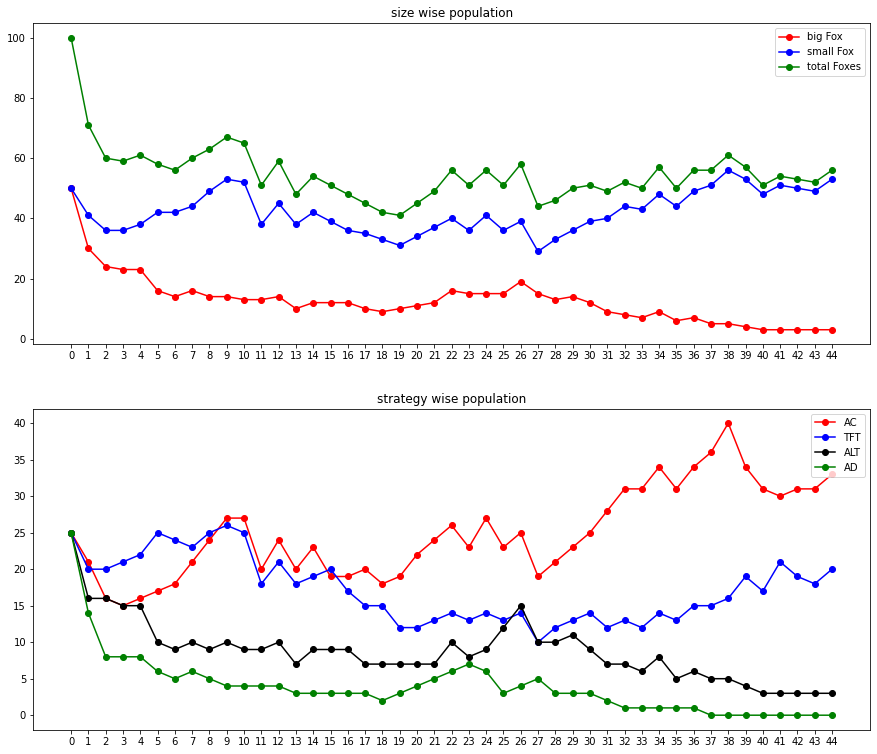

In [ ]:
# Run sim
e.run(n)

In [ ]:
# Get Current Population
e.getPopNumber()

56


# **Sim number 2 , AD is dominant**

In [ ]:
pop_of_strat = {'AC':[0],'TFT':[0],'ALT':[0],'AD':[0]}
pop_of_size = {1:[0],2:[0]}

In [ ]:
# In this one I am showing a condition where AD is most favourable.
# for this , eliminating the TFT type is important
# or else AD will get punished for non cooperation.

e = Environment(foodperday=60,repChance=1)


n1 = 40   #number of iterations

# Initializing agents

agents=[]
for i in range(25):
    agents.append(Agent(1,'AD'))
for i in range(25):
    agents.append(Agent(2,'AC'))
#for i in range(25):
 #   agents.append(Agent(1,'TFT'))
for i in range(25):
    agents.append(Agent(1,'ALT'))


e.setup(agents)


population :  75


Iteration 0/40: TotalPopulation = 44 , Bigfox = 15 , Smallfox = 29
Iteration 1/40: TotalPopulation = 39 , Bigfox = 13 , Smallfox = 26
Iteration 2/40: TotalPopulation = 41 , Bigfox = 14 , Smallfox = 27
Iteration 3/40: TotalPopulation = 43 , Bigfox = 10 , Smallfox = 33
Iteration 4/40: TotalPopulation = 43 , Bigfox = 12 , Smallfox = 31
Iteration 5/40: TotalPopulation = 39 , Bigfox = 6 , Smallfox = 33
Iteration 6/40: TotalPopulation = 39 , Bigfox = 5 , Smallfox = 34
Iteration 7/40: TotalPopulation = 38 , Bigfox = 5 , Smallfox = 33
Iteration 8/40: TotalPopulation = 37 , Bigfox = 4 , Smallfox = 33
Iteration 9/40: TotalPopulation = 36 , Bigfox = 4 , Smallfox = 32
Iteration 10/40: TotalPopulation = 33 , Bigfox = 3 , Smallfox = 30
Iteration 11/40: TotalPopulation = 35 , Bigfox = 2 , Smallfox = 33
Iteration 12/40: TotalPopulation = 39 , Bigfox = 3 , Smallfox = 36
Iteration 13/40: TotalPopulation = 35 , Bigfox = 2 , Smallfox = 33
Iteration 14/40: TotalPopulation = 37 , Bigfox = 2 , Smallfox = 35


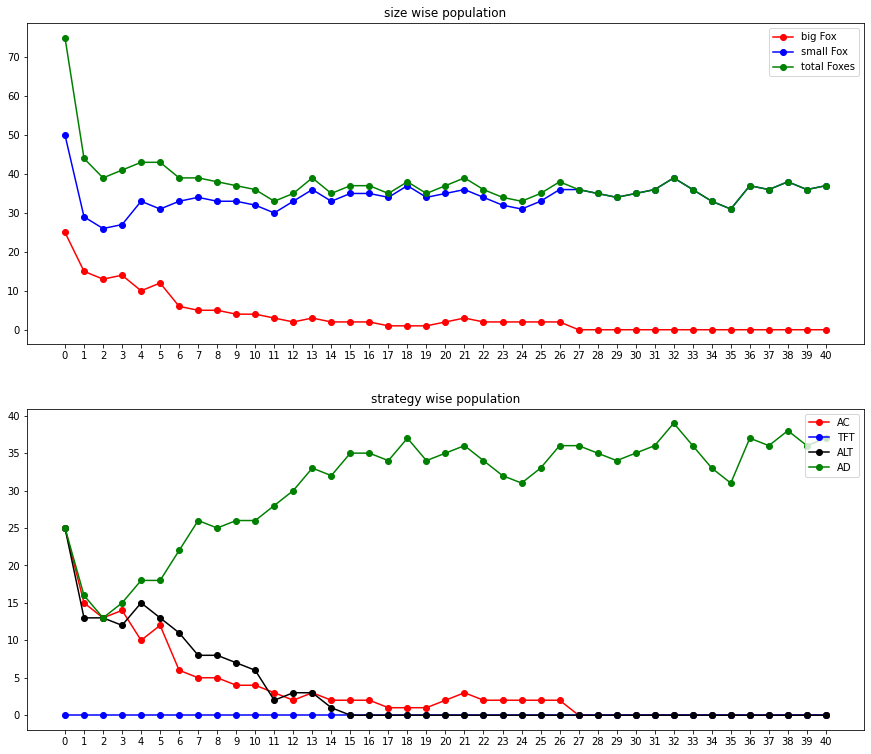

In [ ]:
e.run(n1)

In [ ]:
e.getPopNumber()

37

# **Conclusion**

Lets assume there is no size difference for the sake of simplicity.

In sim 1, the AC and TFT strategy dominate when repChance is low and number of iterations is high since in the long run with high iterations they will punish the AD strategy . One can argue that since AD shares less , it has stored more food than others so by reproducing it will increase it's population, this is true but even after this , repChance is deliberately kept low and hence AD won't survive.

Now coming on to sim 2, number of iterations is low and repChance is high so AD is Most optimal since in the short run other's won't get to punish AD and it will also have high chance of reproduction. 

# **Implementational Details**

We are initializing the agents with some attributes like size, id, strategy, etc. Each agent has a unique id which is unique because it is the number of agents which have lived till then. 

Then we initialize the environment. An environment is modelled as an n by n matrix. Each cell can host 1 unit of food, or 1 agent and then rounds of day and night follow .In one round of day and night i.e one iteration, agents get spawned at random places in an empty grid, similarly grid is also populated with food on a daily basis. The nearest agent gets the food and in case of conflict , you can refer to the priority of directions. We used BFS algorithm to accomplish this.

The priority order of the directions is as follows.


```
dirn =[(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
```
note : these directions are on a basis of row,column and **NOT** on the standard x-axis,y-axis .



Now at night , each agent is checked for food and  three cases arise:


*   case 1 , 0 units of food : If it has no food it will probably get eliminated. why probably ? let's see in the next point. 
*   case 2 , more than 1 units of food : If the agents have more than 1 unit of food ,they can decide whether to share food or not based on their strategy and also on the strategy of the one at mercy (hence the name atmercy was alloted to that agent). This sharing of food can save an agent who was going to die.
*   case 3 , more than 2 units of food : Now they can decide on whether to reproduce or not based on a fixed probability provided by us.

Let us understand sharing in more detail.

Sharing is done based on punishing the non cooperative ones. The one who has shared his food before, gets more chance of getting food through sharing than the one who didn't. Have a lookat the code which decides the probability of sharing.
```
prob = (agent.size/(atmercy.size+agent.size))*agent.strat[0]*(atmercy.strat[-1] if atmercy.strat != [] else 1)
```
We can clearly see that AD, the acceptor, has a less chance of getting food shared by AC,the donor, (I am calculating relative probability) since his sharing probability is very much less than other agents and hence AD is punished.

While discussing all these , we have ignored the fact that there is a size difference between the foxes. So let us talk about it.
We have hard-coded our probability in such a way that the small foxes have more probability of getting shared food. This is evident from the code above.
